# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
# Import libraries necessary for this project
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Print only 2 decimal places
np.set_printoptions(precision=2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [3]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.00,440.00,440.00,440.00,440.00,440.00
mean,12000.30,5796.27,7951.28,3071.93,2881.49,1524.87
std,12647.33,7380.38,9503.16,4854.67,4767.85,2820.11
min,3.00,55.00,3.00,25.00,3.00,3.00
25%,3127.75,1533.00,2153.00,742.25,256.75,408.25
50%,8504.00,3627.00,4755.50,1526.00,816.50,965.50
75%,16933.75,7190.25,10655.75,3554.25,3922.00,1820.25
max,112151.00,73498.00,92780.00,60869.00,40827.00,47943.00


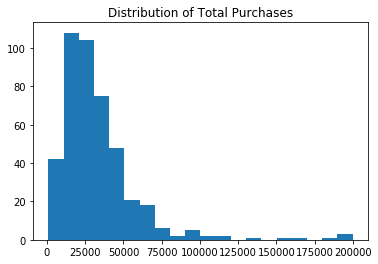

In [4]:
total_purchases = data.sum(axis=1)

plt.figure()
plt.title("Distribution of Total Purchases")
plt.hist(total_purchases, bins=20)
plt.show()

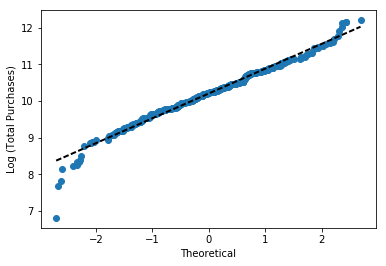

In [5]:
def qqnorm(empirical, name=None):
    np.random.seed(123321)
    theoretical = np.random.normal(0, 1, len(empirical))
    theoretical.sort()
    empirical = sorted(empirical)
    plt.plot(theoretical, empirical, 'o')
    plt.xlabel("Theoretical")
    plt.ylabel(name or "Experimental")
    
    coefs = np.polyfit(theoretical, empirical, 1)
    f_line = np.poly1d(coefs)
    plt.plot(theoretical, f_line(theoretical),"k--", linewidth=2)

qqnorm(np.log(total_purchases), "Log (Total Purchases)")
plt.show()

### Visualization: Purchase Behavior
The *Total Purchases* appears to follow a [Log-Normal](https://en.wikipedia.org/wiki/Log-normal_distribution) distribution. Let's see how the 10% lowest spenders compare to the 10% highest spenders.

Summary on Low Spenders


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
154,622,55,137,75,7,8
97,403,254,610,774,54,63
98,503,112,778,895,56,132
355,190,727,2012,245,184,127
131,2101,589,314,346,70,310
275,680,1610,223,862,96,379
327,542,899,1664,414,88,522
299,444,879,2060,264,290,259
352,608,1106,1533,830,90,195
203,583,685,2216,469,954,18


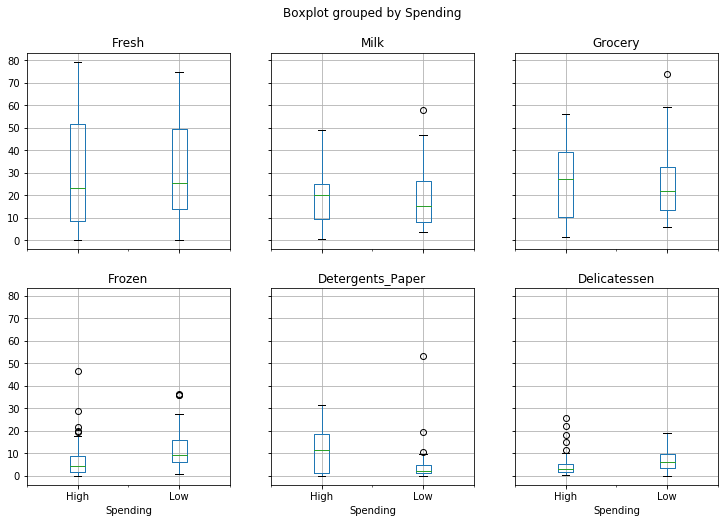

In [6]:
n_rows, n_cols = data.shape

purchase_percent = data.div(total_purchases, axis=0) * 100
sorted_purchases = total_purchases.sort_values()

lowest = purchase_percent.loc[sorted_purchases.index[:int(n_rows * 0.1)]]
lowest['Spending'] = 'Low'
print("Summary on Low Spenders")
display(data.loc[sorted_purchases.index[:10]])

highest = purchase_percent.loc[sorted_purchases.index[int(n_rows * 0.9):]]
highest['Spending'] = 'High'

high_and_low = pd.concat([highest, lowest])
high_and_low.boxplot(list(data.columns), by='Spending', figsize=(12, 8), layout=(2, 3))
plt.show()

The main difference between purchasing habits in groups appears on variables **Frozen, Detergents_Paper and Delicatessen**. Clients that spend more tend to buy more (relatively speaking) on Detergents and Paper and less on Frozen Goods and Delicatessen than clients spending less.

### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [7]:
indices = [65, 258, 384]
print("Chosen indices were {}, {} and {}".format(*indices))

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen indices were 65, 258 and 384
Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,85,20959,45828,36,24231,1423
1,56083,4563,2124,6422,730,3321
2,10683,21858,15400,3635,282,5120


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  

* What kind of establishment (customer) could each of the three samples you've chosen represent?

**Hint:** Examples of establishments include places like markets, cafes, delis, wholesale retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant. You can use the mean values for reference to compare your samples with. The mean values are as follows:

* Fresh: 12000.2977
* Milk: 5796.2
* Frozen: 3071.9
* Grocery: 7951.2
* Detergents_paper: 2881.4
* Delicatessen: 1524.8

Knowing this, how do your samples compare? Does that help in driving your insight into what kind of establishments they might be?


**Answer:**

The first choice might be some kind of grocery / market because of the high spending (both absolute and relative) in Grocery and Detergents / Paper and very low spending on Fresh (perhaps buying it somewhere else). Overall, spending of Detergents and Paper is low (it has the lowest median of the 6), so this example got my attention. Markets should be fewer in number but I would expect them to spend much more than the general customer.

The second choice might be a restaurant, as Fresh exceeds other categories by a large margin.

The third choice might be a cafeteria / bakery. The proportion of milk when compared the total spendings is higher than expected from a restaurant, which made me think of a cafeteria. It is not a supermarket either, because Detergents / Paper would be higher in that case. Finally, Grocery and Delicatessen purchases were high, making bakery a possibility, too.

As for the means, they were not very useful for this task. The variables are very skewed, which might make them misleading. Also, customers vary in size: a small restaurant whose purchases are mainly Fresh could still spend less on Fresh than than a big supermarket that doesn't purchase Fresh as frequently but makes big purchases over all categories.
My strategy was to look at relative spending on each variable and combine with the total spending. It would be unlikely that a market or hotel would be among low spenders.


### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [8]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor


for col_to_remove in data:
    # Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    new_data = data.drop(col_to_remove, axis=1)

    # Split the data into training and testing sets(0.25) using the given feature as the target
    # Set a random state.
    X_train, X_test, y_train, y_test = train_test_split(new_data, data[col_to_remove], \
                                                        test_size=0.25, \
                                                        random_state=4242)

    # Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(random_state=4242).fit(X_train, y_train)

    # Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    print("R2 Score for Regression on '{}': {:.2f}".format(col_to_remove, score))

R2 Score for Regression on 'Fresh': -0.58
R2 Score for Regression on 'Milk': 0.16
R2 Score for Regression on 'Grocery': 0.72
R2 Score for Regression on 'Frozen': -8.52
R2 Score for Regression on 'Detergents_Paper': 0.62
R2 Score for Regression on 'Delicatessen': -0.67


### Question 2

* Which feature did you attempt to predict? 
* What was the reported prediction score? 
* Is this feature necessary for identifying customers' spending habits?

**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data. If you get a low score for a particular feature, that lends us to beleive that that feature point is hard to predict using the other features, thereby making it an important feature to consider when considering relevance.

**Answer:**

#### Which feature did you attempt to predict?
I was too curious to predict only one, so I went forth and attempted all features, but let's pretend that I chose **Detergents_Paper**.

#### What was the reported prediction score?

0.62

#### Is this feature necessary for identifying customers' spending habits?

Not much. The score made clear that most of the feature variation can explained by the others. In a practical sense, it might give us insight on purchasing habits (customers who bought X also bought Y).

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

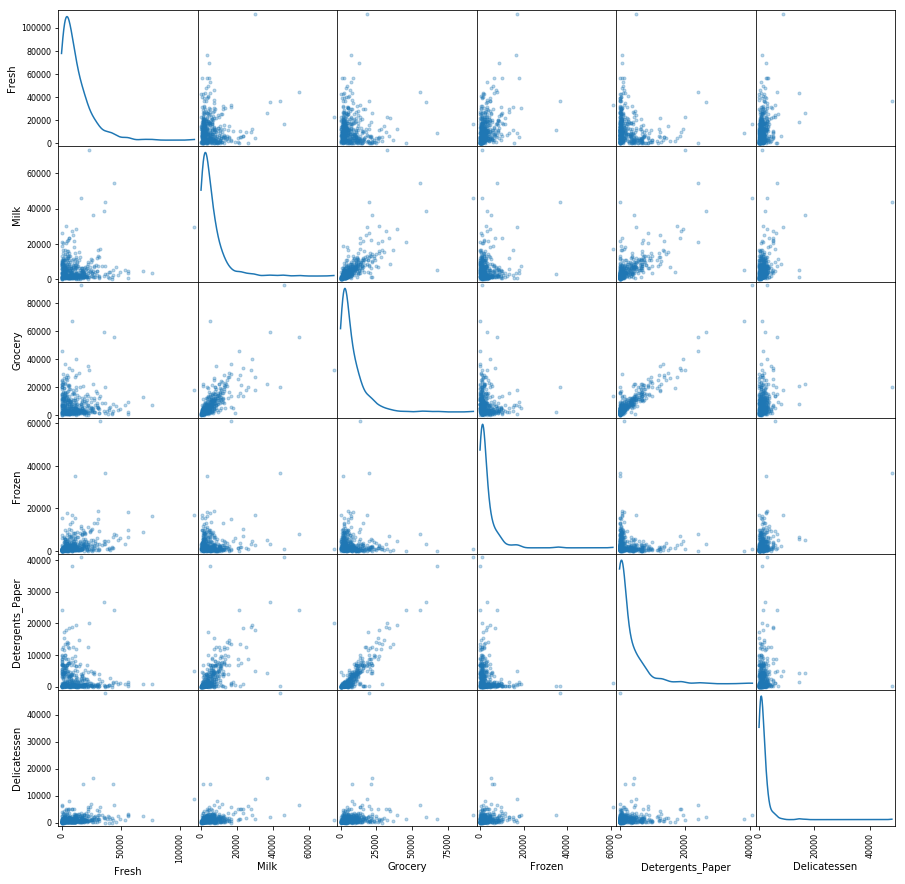

In [9]:
# Produce a scatter matrix for each pair of features in the data
n_rows, n_cols = data.shape
pd.scatter_matrix(data, alpha = 0.3, figsize=(n_cols * 2.5, n_cols * 2.5), diagonal = 'kde');

The features are very skewed like the Total Purchases plot we've seen previously, pointing towards a Log-Normal distribution. We can verify the hypothesis using Quantile-Quantile plots.

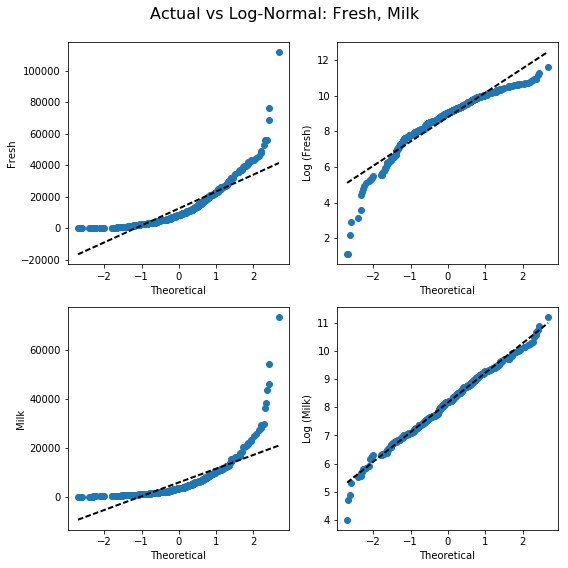

In [10]:
def compare_distributions(column, subplot_left, subplot_right):
    plt.subplot(subplot_left)
    qqnorm(data[column], column)
    plt.subplot(subplot_right)
    qqnorm(np.log(data[column]), "Log ({})".format(column))

plt.figure(figsize=(8, 8))
compare_distributions('Fresh', 221, 222)
compare_distributions('Milk', 223, 224)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Actual vs Log-Normal: Fresh, Milk', fontsize=16)
plt.show()

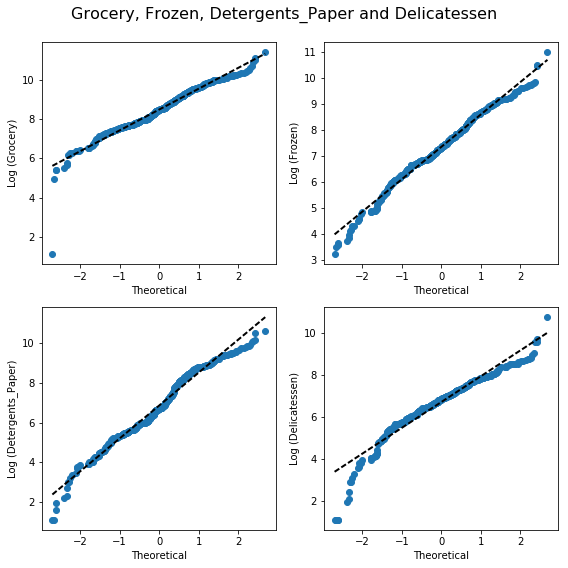

In [11]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
qqnorm(np.log(data['Grocery']), 'Log (Grocery)')
plt.subplot(222)
qqnorm(np.log(data['Frozen']), 'Log (Frozen)')
plt.subplot(223)
qqnorm(np.log(data['Detergents_Paper']), 'Log (Detergents_Paper)')
plt.subplot(224)
qqnorm(np.log(data['Delicatessen']), 'Log (Delicatessen)')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Grocery, Frozen, Detergents_Paper and Delicatessen', fontsize=16)
plt.show()

`Fresh` appears off, but the remaining variables appear to be log-normal.

Also, on the pairs plot, we see an interesting linear relationship between Milk, Grocery and Detergent / Paper. All of them are typically sold by groceries and markets, which might explain the trend. Let's dig deeper by plotting a correlation matrix.

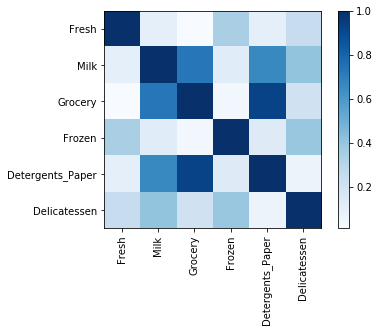

Most Correlated:


[('Milk', 'Detergents_Paper', 0.66181567935910635),
 ('Grocery', 'Milk', 0.72833511815364449),
 ('Detergents_Paper', 'Grocery', 0.9246406908542677)]

Least Correlated:


[('Fresh', 'Grocery', -0.011853874984010492),
 ('Frozen', 'Grocery', -0.040192736990591241),
 ('Detergents_Paper', 'Delicatessen', 0.069291297458373952)]

In [12]:
# TO REVIEWER:
# I wrote the correlation heatmap below before reading the following cell containing instructions,
# so I decided to leave it as it is, because the results are valid

def correlation_matrix_from(dataframe):
    return np.corrcoef(dataframe, rowvar=False)

def corr_plot(dataframe):
    corr_matrix = correlation_matrix_from(dataframe)
    size = len(corr_matrix)
    
    plt.imshow(np.abs(corr_matrix), cmap=plt.cm.Blues, interpolation='nearest')
    plt.xticks(range(size), dataframe.columns, rotation=90)
    plt.yticks(range(size), dataframe.columns)
    plt.colorbar()
    plt.show()

def least_to_most(dataframe):
    corr_matrix = correlation_matrix_from(dataframe)
    size = len(corr_matrix)
    
    def sort_correlations():
        abs_corr_matrix = np.abs(corr_matrix)
        arg_sorted = np.argsort(abs_corr_matrix, axis=None)[:-size:2]  # Remove diagonals
        ix, iy = np.unravel_index(arg_sorted, abs_corr_matrix.shape)
        return ix, iy, corr_matrix.ravel()[arg_sorted]
    
    f1, f2, vals = sort_correlations()
    return list(zip(dataframe.columns[f1], dataframe.columns[f2], vals))


corr_plot(data)
ordered_correlations = least_to_most(data)

print("Most Correlated:")
display(ordered_correlations[-3:])

print("Least Correlated:")
display(ordered_correlations[:3])

### Question 3
* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well.
* Are there any pairs of features which exhibit some degree of correlation? 
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? 
* How is the data for those features distributed?

**Hint:** Is the data normally distributed? Where do most of the data points lie? You can use [corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to get the feature correlations and then visualize them using a [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html)(the data that would be fed into the heatmap would be the correlation values, for eg: `data.corr()`) to gain further insight.

**Answer:**

**Normality**: Except for the `Fresh` feature, the features exhibit a [log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution) distribution. Interestingly, the values near the lower bounds are much more extreme than we would expect, given the overall trend in the data.

**Outliers**: As noted on the `Normality` item, smallest values of each feature are more extreme than expected. This might happen because external factors can play a greater role for small customers (seasonality, greater price sensitivity, et cetera). On the other end of the spectrum, we have some clients purchasing large amounts of products, as expected for a log-normal, but, when we look at the ratios, the discrepancy is bigger on `Frozen` and `Delicatessen` goods (take a look at the box plot above [Question 1](#Visualization:-Purchase-Behavior)).

**Mode**: Looking at the distribution of each feature, we can see that the mode sits near zero for all of them. Drawing insights from our human knowledge, we know that the number of small businesses is much greater than the number of large ones. The data reflects the fact that small business make small purchases, thus, standing near zero. Also, there is no upper bound (virtually speaking) on how much one client can spend, but there is one lower bound: **zero**.

**Correlation**: `Grocery` and `Detergents_Paper` exhibited a high degree of linear correlation, which indicates that clients might be purchasing them together, as it was hypothesized on [Question 2](#Question-2).  To a lesser degree, `Milk` correlates with `Grocery` and `Detergents_Paper` too. The least correlated are `Grocery` to `Fresh` and `Frozen`, meaning that knowing `Fresh` and `Frozen` values will give us little to no information on `Grocery`.

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

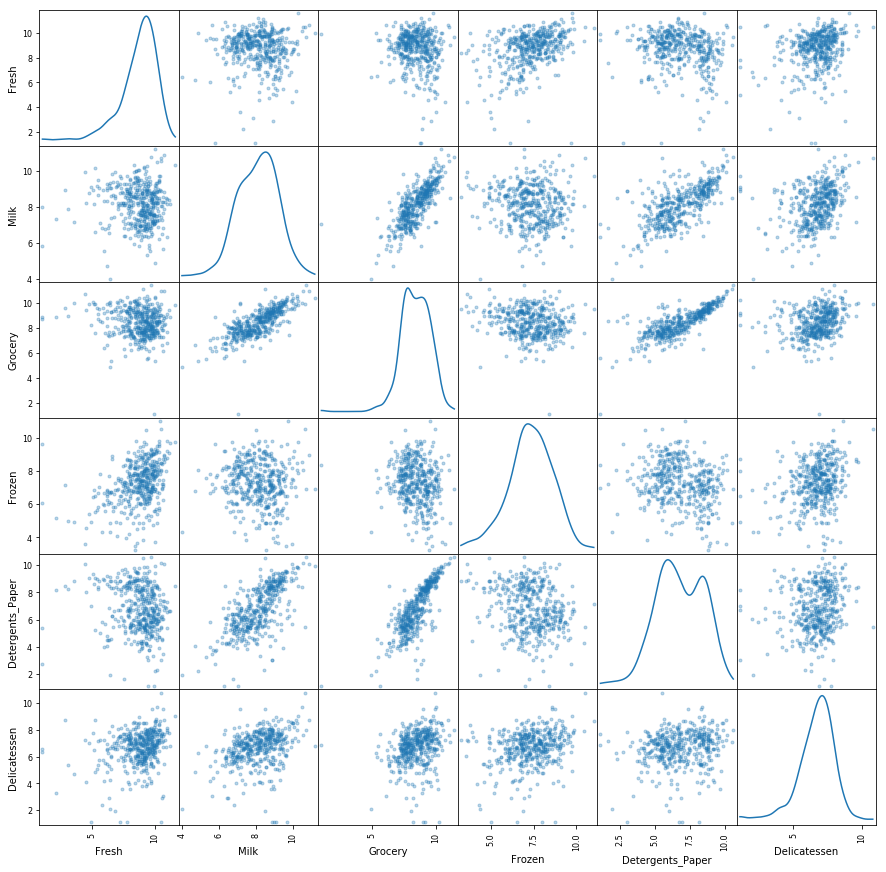

In [13]:
# Scale the data using the natural logarithm
log_data = data.apply(np.log)

# Scale the sample data using the natural logarithm
log_samples = samples.apply(np.log)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (n_cols * 2.5, n_cols * 2.5), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,4.44,9.95,10.73,3.58,10.10,7.26
1,10.93,8.43,7.66,8.77,6.59,8.11
2,9.28,9.99,9.64,8.20,5.64,8.54


Correlation of transformed features:


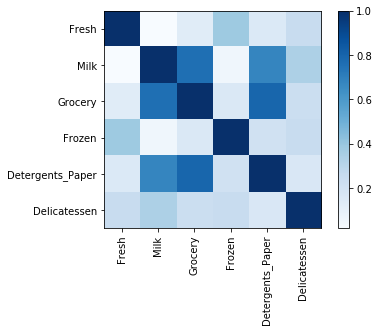

Most Correlated:
Old


[('Milk', 'Detergents_Paper', 0.66181567935910635),
 ('Grocery', 'Milk', 0.72833511815364449),
 ('Detergents_Paper', 'Grocery', 0.9246406908542677)]

New


[('Milk', 'Detergents_Paper', 0.67794242437281538),
 ('Grocery', 'Milk', 0.75885089692086982),
 ('Grocery', 'Detergents_Paper', 0.79639773732131491)]

----------
Least Correlated:
Old


[('Fresh', 'Grocery', -0.011853874984010492),
 ('Frozen', 'Grocery', -0.040192736990591241),
 ('Detergents_Paper', 'Delicatessen', 0.069291297458373952)]

New


[('Fresh', 'Milk', -0.019833977501284877),
 ('Frozen', 'Milk', -0.055315886805106913),
 ('Fresh', 'Grocery', -0.1327129137609025)]

In [14]:
# Display the log-transformed sample data
display(log_samples)

# Compare correlations before vs after transformation
print("Correlation of transformed features:")
corr_plot(log_data)
new_ordered_correlations = least_to_most(log_data)

print("Most Correlated:")
print("Old")
display(ordered_correlations[-3:])
print("New")
display(new_ordered_correlations[-3:])

print("-" * 10)

print("Least Correlated:")
print("Old")
display(ordered_correlations[:3])
print("New")
display(new_ordered_correlations[:3])

### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [15]:
def keys_where_true(series):
    return ','.join(series.index[series.values])


def detect_outliers(series, l_factor=1.5, u_factor=1.5, bounds=False):
    assert l_factor > 0
    assert u_factor > 0
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    q1 = np.percentile(series, 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    q3 = np.percentile(series, 75)
    
    iqr = q3 - q1
    lower_bound = q1 - l_factor * iqr
    upper_bound = q3 + u_factor * iqr
    outliers_mask = (series < lower_bound) | (series > upper_bound)
    
    return (outliers_mask, lower_bound, upper_bound) if bounds else outliers_mask


# For each feature find the data points with extreme high or low values
for feature, feature_data in log_data.iteritems():
    outliers, l_bound, u_bound = detect_outliers(feature_data, bounds=True)
    
    # Display the outliers
    print("Data points outside range [{:.2f}, {:.2f}] for feature '{}':".format(l_bound, u_bound, feature))
    display(log_data[outliers])

    
# TO REVIEWER: Please read
# I relaxed the LOWER BOUNDARY of outlier detection by using 2.0 instead of 1.5 as multiplier of IQR
print("Selected outliers according to my criteria:")
outliers_names = log_data.apply(lambda x: detect_outliers(x, 2)).apply(keys_where_true, axis=1)
outliers_data = log_data.copy()
outliers_data['Outliers'] = outliers_names
outliers = outliers_names != ''
display(outliers_data[outliers])

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers])
original_good_data = data.drop(log_data.index[outliers])

print("Discarded Outliers: {}".format(len(log_data) - len(good_data)))

Data points outside range [5.51, 12.27] for feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.44,9.95,10.73,3.58,10.10,7.26
66,2.20,7.34,8.91,5.16,8.15,3.30
81,5.39,9.16,9.58,5.65,8.96,5.05
95,1.10,7.98,8.74,6.09,5.41,6.56
96,3.14,7.87,9.00,4.98,8.26,5.38
128,4.94,9.09,8.25,4.96,6.97,1.10
171,5.30,10.16,9.89,6.48,9.08,8.74
193,5.19,8.16,9.92,6.87,8.63,6.50
218,2.89,8.92,9.63,7.16,8.48,8.76
304,5.08,8.92,10.12,6.42,9.37,7.79


Data points outside range [5.02, 11.20] for feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.04,11.21,10.38,6.89,9.91,6.81
98,6.22,4.72,6.66,6.80,4.03,4.88
154,6.43,4.01,4.92,4.32,1.95,2.08
356,10.03,4.90,5.38,8.06,2.20,6.31


Data points outside range [5.28, 11.67] for feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.92,7.04,1.10,8.39,1.10,6.88
154,6.43,4.01,4.92,4.32,1.95,2.08


Data points outside range [4.26, 10.53] for feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.43,9.66,9.72,3.50,8.85,6.07
57,8.60,9.20,9.26,3.64,8.93,7.16
65,4.44,9.95,10.73,3.58,10.10,7.26
145,10.00,9.03,10.46,3.74,9.44,8.40
175,7.76,8.97,9.38,3.95,8.34,7.44
264,6.98,9.18,9.65,4.11,8.70,7.14
325,10.40,9.73,9.52,11.02,7.15,8.63
420,8.40,8.57,9.49,3.22,8.83,7.24
429,9.06,7.47,8.18,3.85,4.43,7.82
439,7.93,7.44,7.83,4.17,6.17,3.95


Data points outside range [1.46, 12.36] for feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.92,7.04,1.10,8.39,1.10,6.88
161,9.43,6.29,5.65,7.00,1.10,7.71


Data points outside range [3.77, 9.75] for feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.20,7.34,8.91,5.16,8.15,3.30
109,7.25,9.72,10.27,6.51,6.73,1.10
128,4.94,9.09,8.25,4.96,6.97,1.10
137,8.03,9.00,9.02,6.49,6.58,3.58
142,10.52,8.88,9.02,8.00,3.00,1.10
154,6.43,4.01,4.92,4.32,1.95,2.08
183,10.51,10.69,9.91,10.51,5.48,10.78
184,5.79,6.82,8.46,4.30,5.81,2.40
187,7.80,8.99,9.19,8.74,8.15,1.10
203,6.37,6.53,7.70,6.15,6.86,2.89


Selected outliers according to my criteria:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,Outliers
65,4.44,9.95,10.73,3.58,10.10,7.26,Fresh
66,2.20,7.34,8.91,5.16,8.15,3.30,Fresh
75,9.92,7.04,1.10,8.39,1.10,6.88,Grocery
86,10.04,11.21,10.38,6.89,9.91,6.81,Milk
95,1.10,7.98,8.74,6.09,5.41,6.56,Fresh
96,3.14,7.87,9.00,4.98,8.26,5.38,Fresh
109,7.25,9.72,10.27,6.51,6.73,1.10,Delicatessen
128,4.94,9.09,8.25,4.96,6.97,1.10,Delicatessen
142,10.52,8.88,9.02,8.00,3.00,1.10,Delicatessen
154,6.43,4.01,4.92,4.32,1.95,2.08,"Milk,Delicatessen"


Discarded Outliers: 22


### Question 4
* Are there any data points considered outliers for more than one feature based on the definition above? 
* Should these data points be removed from the dataset? 
* If any data points were added to the `outliers` list to be removed, explain why.

** Hint: ** If you have datapoints that are outliers in multiple categories think about why that may be and if they warrant removal. Also note how k-means is affected by outliers and whether or not this plays a factor in your analysis of whether or not to remove them.

**Answer:**

Some data points are considered outliers in two or three categories, too. See the table at the end of the above cell to get more details.

Although removing outliers is often a good practice, we need to proceed with caution. The intervals given by Tukey Method is comparable to intervals constructed using 2.5 standard deviations above and below feature's mean, which, under a normal distribution, is expected to enclose 98.76% of population data. On other words, we can expected around 5.5 outliers for each feature in a sample of 440.

Interesting enough, features `Frozen`, `Fresh` and `Delicatessen` have at least two times more outliers than expected. Another particularity in the data is the fact that most of the outliers found lie below the interval given by Tukey Method, leading me to believe that those outliers may be part of some structure in the data. I ended up deciding to keep them around, except for the most extreme cases, which might hurt cluster centroids and introduce artificial variance to data.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

Analysis of PCA Results on Data


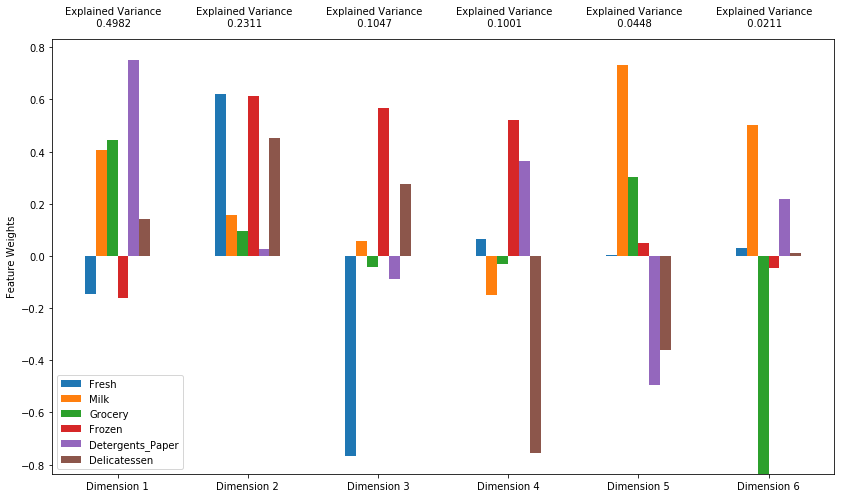

In [16]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=n_cols).fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
print("Analysis of PCA Results on Data")
pca_results = vs.pca_results(good_data, pca)

### Bonus Implementation: ICA

Just for curiosity, let's repeat what we did with PCA and compare the results.

Analysis of ICA Results on Data


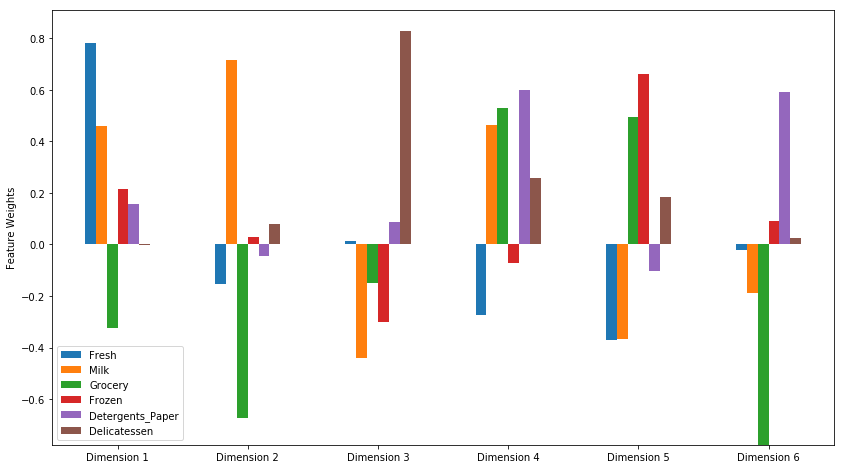

In [17]:
from sklearn.decomposition import FastICA

# Apply ICA by fitting the good data with the same number of dimensions as features
ica = FastICA(n_components=n_cols, random_state=1980).fit(good_data)

# Transform log_samples using the ICA fit above
ica_samples = ica.transform(log_samples)

# Generate ICA results plot
print("Analysis of ICA Results on Data")

# Unlike PCA, ICA components are not l2-normalized, so we need to normalize them in order to compare
ica_results = vs.pca_results(good_data, ica, show_explained_variance=False, norm=2)

At first glance, it seems that the decomposition given by ICA is very different from PCA but, inspecting carefully, we can see some similarities:
- `Dimension 1` on PCA and `Dimension 4` on ICA
- `Dimension 6` on PCA and `Dimension 2` on ICA
- `Dimension 5` on PCA and `Dimension 3` or `Dimension 6` on ICA

### Analyzing PCA Samples

In [18]:
display(pd.concat([pd.DataFrame(pca_samples, columns=pca_results.index), log_samples], axis=1))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,5.58,-4.23,1.11,-1.75,0.02,-0.25,4.44,9.95,10.73,3.58,10.10,7.26
1,-0.72,2.74,-0.35,-0.23,-0.31,0.77,10.93,8.43,7.66,8.77,6.59,8.11
2,0.49,1.97,0.81,-1.60,1.71,-0.33,9.28,9.99,9.64,8.20,5.64,8.54


### Comparing PCA to Original Data
To get a better understanding, let's see the PCA-transformed together with the original data used to fit PCA.

In [19]:
import ipywidgets as widgets
from IPython.html.widgets import interactive

component_data = pd.DataFrame(pca.transform(good_data),
                              index=good_data.index,
                              columns='D' + pd.Series(list('123456')))

items = ['No Sorting'] + component_data.columns.tolist()
order = ['Descending', 'Ascending']
component_data = pd.concat([component_data, original_good_data], axis=1)

def view(sort_by='', with_ord=''):
    result_set = component_data
    if sort_by != 'No Sorting':
        result_set = component_data.sort_values(by=sort_by, ascending=with_ord=='Ascending')
    return result_set.head(10)

select_widget = widgets.Select(options=items)
ordering_widget = widgets.Select(options=order)
interactive(view, sort_by=select_widget, with_ord=ordering_widget)

,D1,D2,D3,D4,D5,D6,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,1.77,-0.41,-1.51,-1.09,0.13,0.46,12669,9656,7561,214,2674,1338
1,1.82,0.68,0.19,-0.17,0.11,0.21,7057,9810,9568,1762,3293,1776
2,1.91,1.44,0.85,-1.09,-0.58,0.35,6353,8808,7684,2405,3516,7844
3,-1.11,1.41,0.51,0.18,-0.68,-0.61,13265,1196,4221,6404,507,1788
4,0.84,2.24,0.07,-0.62,-0.44,0.03,22615,5410,7198,3915,1777,5185
5,1.10,0.06,-0.57,-0.69,0.12,0.56,9413,8259,5126,666,1795,1451
6,1.15,-0.53,-1.34,0.23,-0.42,-0.04,12126,3199,6975,480,3140,545
7,1.60,0.75,0.16,-0.37,-0.53,-0.11,7579,4956,9426,1669,3321,2566
8,0.87,-0.90,-0.71,-0.35,-0.18,-0.02,5963,3648,6192,425,1716,750
9,2.90,0.50,0.02,-0.27,-0.07,-0.10,6006,11093,18881,1159,7425,2098


### Question 5

* How much variance in the data is explained* **in total** *by the first and second principal component? 
* How much variance in the data is explained by the first four principal components? 
* Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.

**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the individual feature weights.

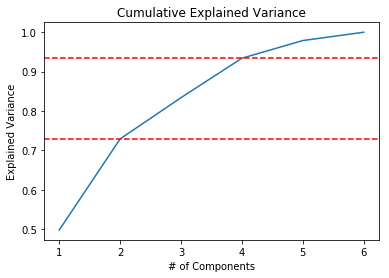

Explained Variance with 2 Components: 0.73
Explained Variance with 4 Components: 0.93


In [20]:
cumulative_explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, n_cols + 1), cumulative_explained_var)
plt.axhline(y=cumulative_explained_var[1], linestyle='--', color='red')
plt.axhline(y=cumulative_explained_var[3], linestyle='--', color='red')
plt.title("Cumulative Explained Variance")
plt.xlabel("# of Components")
plt.ylabel("Explained Variance")
plt.show()

print("Explained Variance with 2 Components: {:.2f}".format(cumulative_explained_var[1]))
print("Explained Variance with 4 Components: {:.2f}".format(cumulative_explained_var[3]))

**Answer:**

For explained variance, refer to the plot above. As for the meaning of the dimensions, here they are:

#### Dimension 1
Remember the correlated features from earlier? They are back! `Detergents_Paper`, `Grocery` and `Milk` appear as the highest weights on this component, with `Detergents_Paper` being the most distinctive of them. Even if we choose this dimension as the only component, about half of the data would be explained (not bad) and we would get a single value that, according to my interpretation, represents how **supermarket-related** are the customer purchases (positive and negative values indicating high and low relatedness, respectively).

The small negative weights on `Fresh` and `Frozen` that purchasing these items will reduce D1 value by a small amount. If the same customer made an additional purchase of `Detergents_Paper`, `Grocery` or `Milk`, the change would be reversed because the positive weights are much bigger than the negatives. Notice that increasing all the features by the same amount will produce a positive change. This may indicate that D1 has some kind of preference for big purchases.

#### Dimension 2
This dimension works almost as the opposite of the first one: `Fresh` and `Frozen`, which had negative weights on D1, are positive and dominate D2 along with `Delicatessen`, also positive. We can expect this component to grow faster by increasing those three. I think that it fits well into what a Restaurant would purchase, making D2 a **restaurant-related** purchase component. It's worthy noting that all weights are positive, meaning no negative values are possible for this dimension given our input data.

The variance explained by this component is 23.11%, half of D1 but still above the threshold of 16.67% (the value we would get if all the 6 components had the same explained variance).

#### Dimension 3
Dimension 3 has same three distinguished features of D2 except that `Fresh` is negative and bigger (in magnitude) than the other two, meaning customers with a high value of D3 are expected to have very low spending in `Fresh`.

The interpreation on this one is harder but if we simplify things a bit, we can write down our intuition as an equation: `Restaurant - Fresh =  ?`. I can think of a **Fast Food** relying on frozen food to prepare meals or some **Convenience Store** selling frozen meals and delicacies. The more positive is D3, the more related to these concepts is the purchase.

The variance explained by this component is 10.47%, less than half of D2 and below the threshold of 16.67% (the value we would get if all the 6 components had the same explained variance). The drop in the explained variance might be due to the fact that the first two dimensions seem to capture the overall concept of **Store vs Foodservice** in the data.

#### Dimension 4
Dominant weights for this component are: `Delicatessen` (negative), `Frozen` and `Detergents_Paper` in that order. As the weight for `Delicatessen` is very negative, meaning customers with a high value of D4 are expected to have very low spending in `Delicatessen`. I can't think of a good explanation for this one: my best guess is that D4 combines with the first two in order to indicate present or absence of a trait. E.g.: Grocery that does not sell household items.

As with the D3, this component seem to work like an adjustment to the first two components in order to allow for richer representations of Store vs Foodservice.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [21]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,5.58,-4.23,1.11,-1.75,0.02,-0.25
1,-0.72,2.74,-0.35,-0.23,-0.31,0.77
2,0.49,1.97,0.81,-1.60,1.71,-0.33


Yes! It seems so.

The first sample, according to my interpretation, was a market. D1, the market-related component, has the highest value among all components.

On the second sample, said to be a restaurant, we can verify that D2, the restaurant-related component, is ahead of the others.

Finally, the third sample was a cafeteria / bakery. This one is not so obvious, but a Cafeteria can be thought as restaurant-related, which is D2. Although it was not asked in the **Question 5**, I think that Dimension 5 is likely to be associated with Cafeterias or Bakeries.

### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [22]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [23]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = reduced_data.columns))

,Dimension 1,Dimension 2
0,5.58,-4.23
1,-0.72,2.74
2,0.49,1.97


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

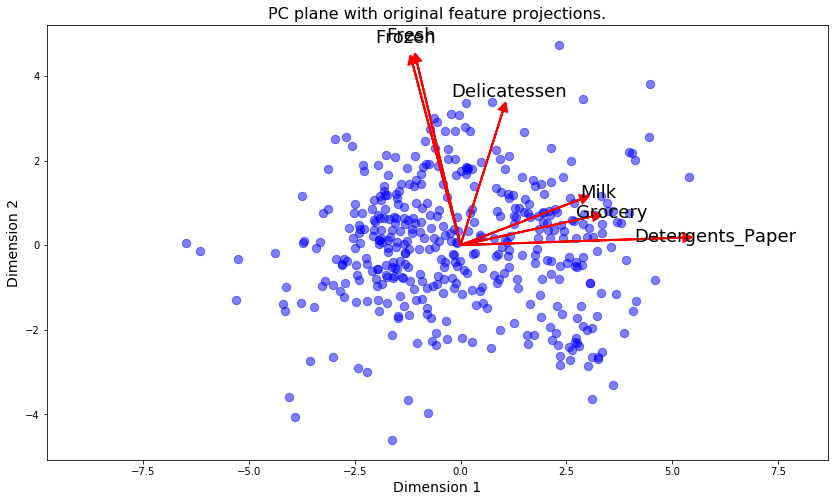

,D1,D2
Fresh,-0.15,0.62
Milk,0.41,0.16
Grocery,0.45,0.10
Frozen,-0.16,0.61
Detergents_Paper,0.75,0.03
Delicatessen,0.14,0.45


In [24]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)
plt.axis('equal')
plt.show()
display(pd.DataFrame(pca.components_.T, index=good_data.columns, columns=['D1', 'D2']))

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

**Answer**

Considering the projections on the axis, we have:
- D1: `Detergents_Paper`, `Grocery`, `Milk`, in that order
- D2: `Fresh`, `Frozen`, `Delicatesen`, in that order

They agree. It is even possible to reconstruct pca_results plot with the information on the biplot (with some errors of measurement).

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6

* What are the advantages to using a K-Means clustering algorithm? 
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

** Hint: ** Think about the differences between hard clustering and soft clustering and which would be appropriate for our dataset.

**Answer:**

#### Advantages of K-Means Clustering
- Faster training and prediction times
- Simpler to understand and implement: if I was in a hurry to implement clustering in JavaScript, I would pick K-Means
- Results are easier to interpret and explain: it is easier to see which is the nearest centroid for a given point

#### Advantages of Gaussian Mixture Model
- More flexible: it makes [less asumptions](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html) about the data (K-Means is, in fact, a special case of GMM)
- It uses Soft Assignment, which gives a probability of points belonging to clusters. This is good in situations where cluster boundaries are fuzzy (e.g. overlapping clusters), enabling us to have a "confidence measure" on the assignment

A comparison of both can be seen [here](https://dcornellresearchdotorg.files.wordpress.com/2015/10/ee6540_final_project-1.pdf).

Looking at the data, I would say that GMM are more likely to give insightful results. It seems to me that the assumption of K-Means about an Isotropic Covariance Matrix will not hold.
Also, Soft Assignment might the result more actionable by giving stakeholders the possibility to define a treshold where the results can be taken seriously.
Finally, the dataset is small enough so that GMM will not have significant impact on running times.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

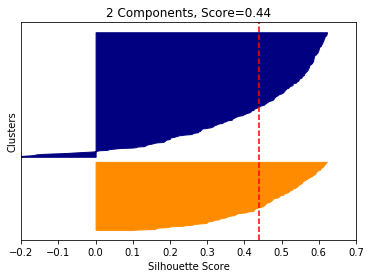

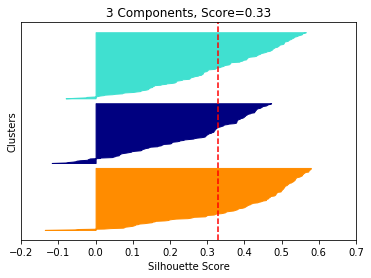

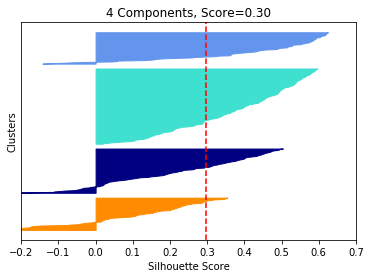

The chosen model was GMM with 2 components with a Silhouette Score of 0.44


In [25]:
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score, silhouette_samples


colors = ['darkorange', 'navy', 'turquoise', 'cornflowerblue']
color_mapping = dict(zip(range(len(colors)), colors))


def silhouette_plot(X, labels):
    plt.xlim([-0.2, 0.7])
    
    y_lower = 10
    silhouette_values = silhouette_samples(X, labels)
    for cluster in set(labels):
        cluster_silhouette_values = silhouette_values[labels == cluster]
        cluster_silhouette_values.sort()
        cluster_size = len(cluster_silhouette_values)
        y_upper = y_lower + cluster_size
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, color=color_mapping[cluster])
        y_lower = y_upper + 10
    
    score = silhouette_score(X, labels)
    plt.axvline(x=score, linestyle='--', color='red')
    plt.title("{} Components, Score={:.2f}".format(n, score))
    plt.xlabel("Silhouette Score")
    plt.ylabel("Clusters")
    plt.yticks([])
    return score
    

best_clt = None
best_score = -1

for n in [2, 3, 4]:
    clt = GMM(n_components=n, random_state=31416, n_init=5).fit(reduced_data)
    score = silhouette_plot(reduced_data, clt.predict(reduced_data))
    if score > best_score:
        best_clt = clt
        best_score = score
    plt.show()

assert best_clt is not None

# Apply your clustering algorithm of choice to the reduced data 
clusterer = best_clt

# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# Find the cluster centers
centers = clusterer.means_

# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# Calculate the mean silhouette coefficient for the number of clusters chosen
score = best_score
print("The chosen model was GMM with {} components with a Silhouette Score of {:.2f}" \
      .format(clusterer.n_components, score))

### Question 7

* Report the silhouette score for several cluster numbers you tried. 
* Of these, which number of clusters has the best silhouette score?

| # Components | Silhouette Score |
|--------------|------------------|
| 2 (Best)     | 0.44             |
| 3            | 0.33             |
| 4            | 0.30             |

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

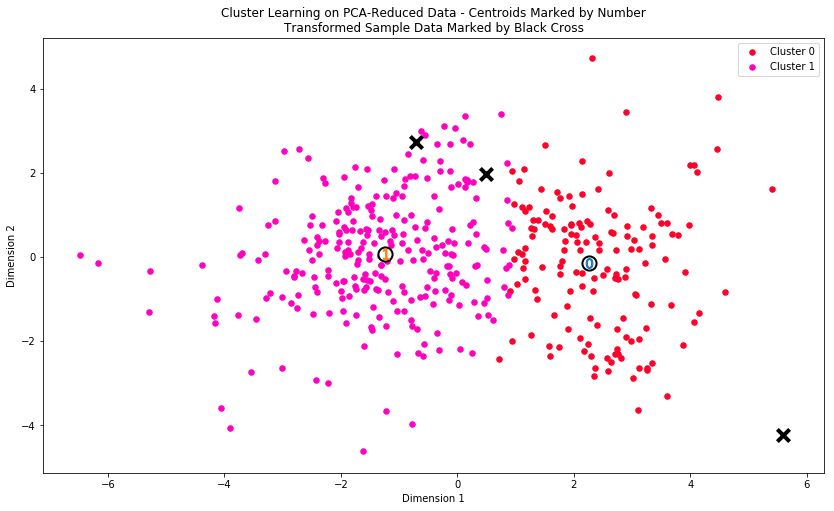

In [26]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Cluster Visualization: Gaussian Ellipsis

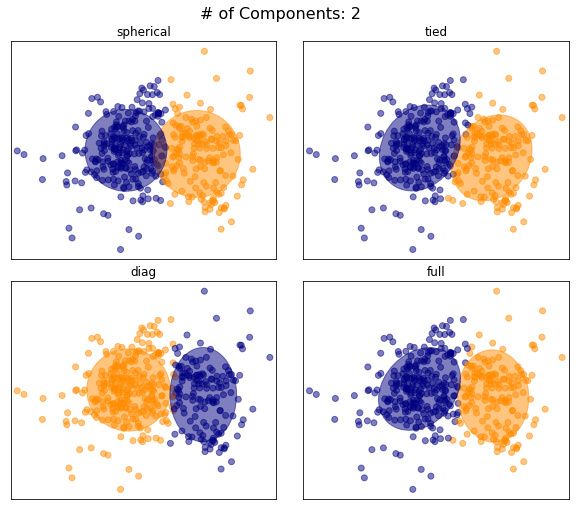

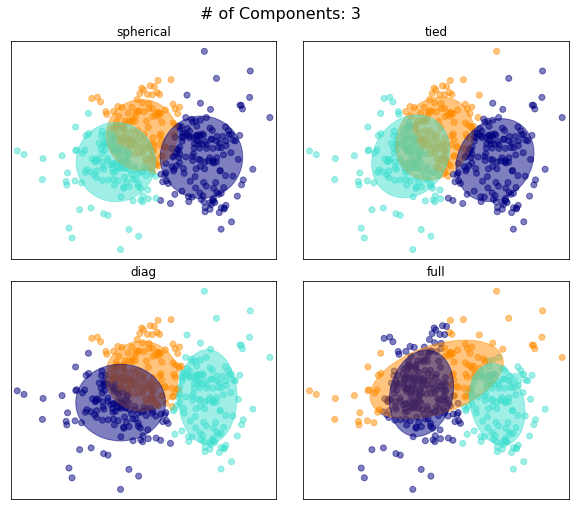

In [27]:
from sklearn.mixture import GMM
    

def plot_clusters(clt, dataframe, ax):
    pred = clt.predict(dataframe)
    ax.axis('equal')
    colors = np.vectorize(color_mapping.get)(pred)
    ax.scatter(dataframe.iloc[:, 0], dataframe.iloc[:, 1], alpha=0.5, color=colors)
    
    
def make_ellipses(gmm, ax):
    import matplotlib as mpl
    
    for n in range(gmm.n_components):
        if gmm.covariance_type == 'full':
            covariances = gmm.covars_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covars_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covars_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covars_[n]

        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1], 180 + angle, color=color_mapping[n])

        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)


for n in [2, 3]:
    fig = plt.figure(figsize=(10, 8))
    fig.subplots_adjust(top=0.92, wspace=0.1, hspace=0.1)
    for index, cov_type in enumerate(['spherical', 'tied', 'diag', 'full']):
        gmm = GMM(n, covariance_type=cov_type, n_init=10).fit(reduced_data)
        ax = plt.subplot(2, 2, index + 1)
        make_ellipses(gmm, ax)
        plot_clusters(gmm, reduced_data, ax)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(cov_type)
    plt.suptitle("# of Components: {}".format(n), fontsize=16)
    plt.show()


### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [28]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
print("Segment Centers (Absolute Values):")
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

print("-" * 5)

print("Segment Centers (% Values):")
display(true_centers.apply(lambda x: 100.0 * x / x.sum(), axis=1))

Segment Centers (Absolute Values):


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,4606.00,8252.00,12445.00,982.00,4918.00,1129.00
Segment 1,8873.00,2046.00,2647.00,1987.00,351.00,754.00


-----
Segment Centers (% Values):


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,14.25,25.52,38.49,3.04,15.21,3.49
Segment 1,53.27,12.28,15.89,11.93,2.11,4.53


### Question 8

* Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project(specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?

**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`. Think about what each segment represents in terms their values for the feature points chosen. Reference these values with the mean values to get some perspective into what kind of establishment they represent.

In [29]:
import functools

def percentile_range(series):
    return np.percentile(series, 70) - np.percentile(series, 30)

def standardize(dataframe, medians, ranges):
    return (dataframe - medians).apply(lambda x: x / ranges[x.name])

standardize_on_data = functools.partial(standardize,
                                        medians=data.median(axis=0),
                                        ranges=data.apply(percentile_range, axis=0))
    
print("Standardized Segment Centers:")
#segment_diff = true_centers - data.median(axis=0)
std_centers = standardize_on_data(true_centers)
display(std_centers)

print("-" * 5)

print("Greatest Value by Feature:")
display(std_centers.idxmax())

Standardized Segment Centers:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,-0.38,1.05,1.19,-0.25,1.44,0.16
Segment 1,0.04,-0.36,-0.33,0.22,-0.16,-0.21


-----
Greatest Value by Feature:


Fresh               Segment 1
Milk                Segment 0
Grocery             Segment 0
Frozen              Segment 1
Detergents_Paper    Segment 0
Delicatessen        Segment 0
dtype: object

**Answer:**

The features distributions are skewed, so I opted for using the **median** instead of mean, as it is a robust measure of centrality.

**Segment 0** prototype customer has superior spending on `Milk`, `Grocery`, `Detergents_Paper` and `Delicatessen` (also above the median) which are product categories more suitable for groceries, markets, delis and the likes.

**Segment 1** prototype customer has superior spending `Fresh` and `Frozen` (also above the median) which are product categories more suitable for restaurants, fast foods and other places serving hot meals.

### Question 9

* For each sample point, which customer segment from* **Question 8** *best represents it? 
* Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [30]:
# Display the predictions
print("Standardized Samples:")
std_samples = standardize_on_data(samples)
display(std_samples)

for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Standardized Samples:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,-0.83,3.95,6.34,-0.70,8.24,0.44
1,4.69,0.21,-0.41,2.29,-0.03,2.29
2,0.21,4.15,1.64,0.99,-0.19,4.03


Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 1


**Answer:**

- Sample point 0 is a very extreme case of Segment 0: `Milk, `Grocery` and Detergents_Paper` are well above the median while `Fresh` and `Frozen` are below, so the prediction is consistent
- Sample point 1 is a extreme case of Segment 1: `Fresh` is well above median and `Frozen` is considerably above too. `Grocery` and `Frozen` are below, so the prediction is consistent
- Sample point 2 is convoluted: It mixes  characteristics from both segments, but `Milk` and `Grocery` are much higher than median than are `Fresh` and `Frozen`. So I would would say that, for this one, prediction was off, but not by much because `Detergents_Paper` is lower than median

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

* How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*

**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

`Segment` is a variable that we want to control for in the experiment we will conduct, so we would need to split our treatment and control groups by Segments, ending up with 4 groups: Treatment for Segment 1, Control for Segment 1, Treatment for Segment 2, Control for Segment 2. This way we can compare appples to apples and see how each of the segments respond to the change.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
* How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?

**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**

We could use the structure we already built, getting the new customer data and running through the tranformation pipeline: log, then pca to finally feed it to our clusterer who will assign a cluster to them.

Another way would be turning the problem to a supervised one where we the original data as features and the segments obtained by clusterer as labels. Then, we can feed the new customer data and get the preditions we need.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

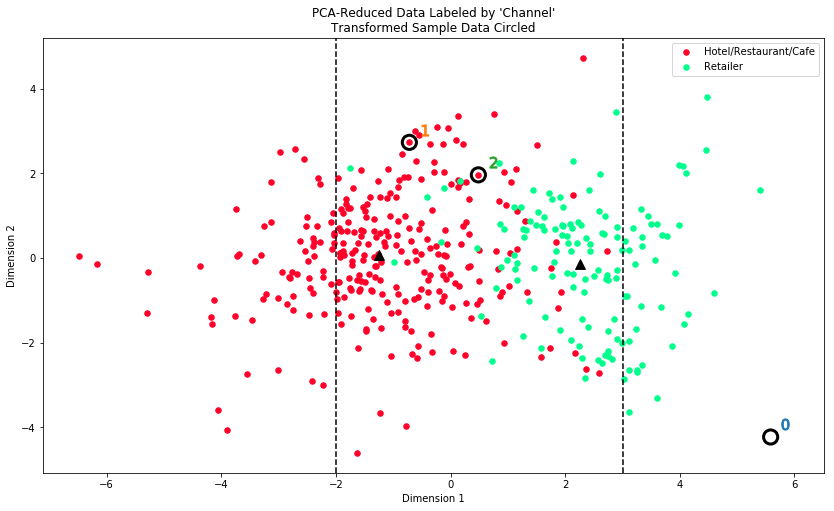

In [31]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)
plt.scatter(centers[:, 0], centers[:, 1], s=96, marker='^', color='black')
plt.axvline(x=-2, linestyle='--', color='black')
plt.axvline(x=3, linestyle='--', color='black')
plt.show()

### Question 12

1. How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? 
2. Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? 
3. Would you consider these classifications as consistent with your previous definition of the customer segments?

**Answer:**

**A1**: I think that the GMM with 2 components, because of soft assignment, does a good job approximating the underlying distribution by capturing some of the uncertainty in the clusters between cluster centers. I marked the cluster centers on the plot with a **black triangle** for better visualization.

**A2**: We could come up with some axis-aligned semi-planes that only have one type of customer segment on them (plus some margin). I drew some dashed lines on the plot to better illustrate.

**A3**: Almost, because with Gaussian Mixtures there is always a chance of spotting an "intruder" in the cluster. If we are willing to ignore that for probabilities below a certain threshold (e.g. 0.01), we could a behavior similar to the one described in the previous item.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.